#  TP - Fuzzy C-Means (FCM)
## Segmentation d’image floue

Installation & imports

---


In [69]:
!pip -q install numpy matplotlib scikit-image

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float

##  1. Téléchargement auto depuis GitHub (une seule image source)


 Déjà présent : data/milky-way.jpg


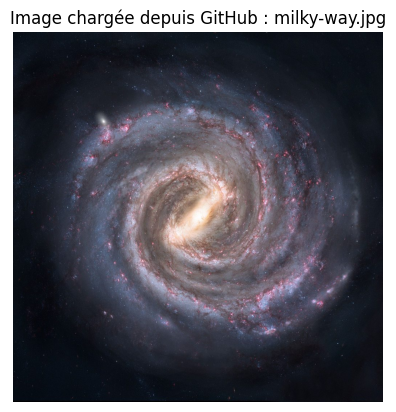

img_raw.shape: (1024, 1024, 3) | ndim: 3


In [70]:
import os, urllib.request

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

G_USER   = "vvazzim"
G_REPO   = "Tp-VMI-Wassim"
G_BRANCH = "main"
G_PATH   = "reco-forme-avancee/tp1-fuzzy-cmeans/data"

FILENAME = "milky-way.jpg"

RAW_URL = f"https://raw.githubusercontent.com/{G_USER}/{G_REPO}/{G_BRANCH}/{G_PATH}/{FILENAME}"
LOCAL_PATH = os.path.join(DATA_DIR, FILENAME)

if not os.path.exists(LOCAL_PATH):
    print(f"Téléchargement de {FILENAME} depuis GitHub…")
    try:
        urllib.request.urlretrieve(RAW_URL, LOCAL_PATH)
        print(" Téléchargé dans", LOCAL_PATH)
    except Exception as e:
        raise RuntimeError(f"Échec du téléchargement : {e}")
else:
    print(" Déjà présent :", LOCAL_PATH)

img_raw = io.imread(LOCAL_PATH)
plt.imshow(img_raw if img_raw.ndim==3 else img_raw,
           cmap=None if img_raw.ndim==3 else 'gray')
plt.title(f"Image chargée depuis GitHub : {FILENAME}")
plt.axis('off'); plt.show()
print("img_raw.shape:", img_raw.shape, "| ndim:", img_raw.ndim)


# 2. Fonctions utilitaires : préparation des données (GRAY/RGB)

In [71]:
def build_data(img_raw, mode="GRAY"):
    if mode == "GRAY":
        I_used = img_as_float(color.rgb2gray(img_raw)) if img_raw.ndim==3 else img_as_float(img_raw)
        X = I_used.reshape(-1, 1)
        C = 2
    else:
        I_used = img_as_float(img_raw)
        if I_used.ndim == 2:
            I_used = np.stack([I_used]*3, axis=-1)
        X = I_used.reshape(-1, 3)
        C = 3
    return I_used, X, C


## 3. Algorithme FCM


In [72]:
import numpy as np

def fcm(X, C=2, m=2.0, eps=1e-4, max_iter=200, verbose=True):
    """
    Fuzzy C-Means (version courte et commentée).
    X: (N,d)  d=1 en GRAY, d=3 en RGB
    """
    N = X.shape[0]
    rng = np.random.default_rng(42)

    U = rng.random((N, C))
    U = U / U.sum(axis=1, keepdims=True)

    it_done = 0
    for it in range(max_iter):
        U_old = U.copy()

        um = U ** m
        den = um.sum(axis=0, keepdims=True).T
        den[den == 0] = 1e-12
        centers = (um.T @ X) / den

        dist = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2) + 1e-12

        power = 2.0 / (m - 1.0)
        denom = (dist[:, :, None] / dist[:, None, :]) ** power
        U = 1.0 / denom.sum(axis=2)

        delta = np.linalg.norm(U - U_old)
        it_done = it + 1
        if verbose and (it % 5 == 0 or delta < eps):
            print(f"[it {it:03d}] ||ΔU||={delta:.3e}")
        if delta < eps:
            if verbose: print(f" Convergence en {it_done} itérations.")
            break

    if it_done == max_iter and verbose:
        print(" ATTENTION : max_iter atteint sans convergence complète.")

    return centers, U, it_done


## 4. Exécution + validations + 3 visualisations : GRAY puis RGB=


In [ ]:
from skimage import color, img_as_float

def run_once(MODE):
    if MODE == "GRAY":
        I_used = img_as_float(color.rgb2gray(img_raw)) if img_raw.ndim==3 else img_as_float(img_raw)
        X = I_used.reshape(-1, 1)
        C = 2
    else:
        I_used = img_as_float(img_raw)
        if I_used.ndim == 2:
            I_used = np.stack([I_used]*3, axis=-1)
        X = I_used.reshape(-1, 3)
        C = 3

    print(f"\n=== Traitement {MODE} ===")
    print(f"X.shape={X.shape} | C={C} | I_used.shape={I_used.shape}")

    centers, U, iters = fcm(X, C=C, m=2.0, eps=1e-4, max_iter=200, verbose=True)

    print(f"\n Centres finaux : {centers.ravel()}")
    print(f" Itérations réalisées : {iters}")
    print(f"∑ U[i,:] (ligne 0) = {U[0].sum():.6f}")

    seg = np.argmax(U, axis=1)
    N = X.shape[0]
    for c in range(C):
        npx = (seg == c).sum()
        print(f"   Cluster {c} : {npx} pixels ({100*npx/N:.1f}%)")

    U1 = U[:, 0].reshape(I_used.shape[:2])
    seg_img = seg.reshape(I_used.shape[:2])

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(I_used if X.shape[1]==1 else I_used[..., :3],
                 cmap='gray' if X.shape[1]==1 else None)
    ax[0].set_title(f"Image ({MODE})"); ax[0].axis('off')

    im1 = ax[1].imshow(U1, cmap='inferno')
    ax[1].set_title("Heatmap (cluster 0)"); ax[1].axis('off')
    plt.colorbar(im1, ax=ax[1], fraction=0.046)

    ax[2].imshow(seg_img, cmap='tab10')
    ax[2].set_title("Segmentation dure (argmax)"); ax[2].axis('off')

    plt.tight_layout(); plt.show()

    os.makedirs("out", exist_ok=True)
    suffix = MODE.lower()
    plt.imsave(f"out/heatmap_cluster1_{suffix}.png", U1, cmap="inferno")
    plt.imsave(f"out/seg_durcie_{suffix}.png", seg_img, cmap="tab10")
    print(f" Sauvegardes dans 'out/' (suffixe: {suffix})")

run_once("GRAY")
run_once("RGB")



=== Traitement GRAY ===
X.shape=(1048576, 1) | C=2 | I_used.shape=(1024, 1024)
[it 000] ||ΔU||=3.464e+02
[it 005] ||ΔU||=2.709e+02
[it 010] ||ΔU||=5.185e+00


# Mini-Exploration de m

In [ ]:
for mm in [1.5, 2.0, 3.0]:
    print(f"\n=== Test m={mm} ===")
    centers_m, U_m, it_m = fcm(X, C=C, m=mm, eps=1e-4, max_iter=200, verbose=False)
    print(f"  itérations : {it_m} | centres : {centers_m.ravel()[:min(3, C)]}")